# Sparkify Project Workspace
Welcome to the Sparkify project, here you will see an analsysis of the small sparkify dataset, and models to predict user churn.

#### EDA Plan
    1. Defined churn
    2. Cleaned for empty user strings, as well as user agents
    3. Split user agent string into platform and browser (bar plot for platform and browser)
    4. Split location column into city and state (bar plot for state)
    5. Converted timestamp into unique day column
    
#### Feature Engineering
    1. Average daily sessions (boxplot)
    2. Average daily thumbs up (boxplot)
    3. Average daily thumbs down (boxplot)
    4. Average daily advertisements
    5. Average daily next song actions
    6. Average daily error actions
    7. Total unique artists listened to
    8. Days passed as a user of the service
    
#### Modeling
    1. Preprocess data
    2. Split into train/test
    3. Check F1 for a few models
    4. Use CV
    5. Check accuracy on both train/test set

In [1]:
# import libraries
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
from pyspark.sql.functions import udf, max, min, lit, when, col, count, countDistinct
from pyspark.sql.types import *

from tabulate import tabulate

import math
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, GBTClassifier, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.feature import StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [2]:
# create a Spark session
spark = SparkSession.builder.appName("EDA  Sparkify").getOrCreate()

In [3]:
path = "./mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [4]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
print(user_log.count(), len(user_log.columns))

286500 18


In [6]:
user_log.show(5)

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|    page| registration|sessionId|                song|status|           ts|           userAgent|userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+--------+-------------+---------+--------------------+------+-------------+--------------------+------+
|  Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|     Bakersfield, CA|   PUT|NextSong|1538173362000|       29|           Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
|Five Iron Frenzy|Logged In|    Micah|     M|           79|    Long|236.09424| free|Boston-Cambridge-...|   PUT|NextSong|1538331630000| 

## *Clean Data for Missing Values*

- After taking a look at the data, I've decided to transform some of the columns

- First, I must ensure that each row has a user

In [7]:
def check_column_values(df, column):
    """
    Show the users in sorted order so anomalous entries will show up at the top
    """
    df.select([column]).dropDuplicates().sort(column).show()

In [8]:
check_column_values(user_log, 'userId')

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
|100008|
|100009|
|100010|
|100011|
|100012|
|100013|
|100014|
|100015|
|100016|
|100017|
+------+
only showing top 20 rows



In [9]:
check_column_values(user_log, 'userAgent')

+--------------------+
|           userAgent|
+--------------------+
|                null|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



In [10]:
check_column_values(user_log, 'location')

+--------------------+
|            location|
+--------------------+
|                null|
|          Albany, OR|
|Albany-Schenectad...|
|      Alexandria, LA|
|Allentown-Bethleh...|
|       Anchorage, AK|
|Atlanta-Sandy Spr...|
|Atlantic City-Ham...|
|Austin-Round Rock...|
|     Bakersfield, CA|
|Baltimore-Columbi...|
|        Billings, MT|
|Birmingham-Hoover...|
|Boston-Cambridge-...|
|         Boulder, CO|
|         Bozeman, MT|
|Bridgeport-Stamfo...|
|Buffalo-Cheektowa...|
|Charlotte-Concord...|
|Chicago-Napervill...|
+--------------------+
only showing top 20 rows



In [11]:
check_column_values(user_log, 'page')

+--------------------+
|                page|
+--------------------+
|               About|
|          Add Friend|
|     Add to Playlist|
|              Cancel|
|Cancellation Conf...|
|           Downgrade|
|               Error|
|                Help|
|                Home|
|               Login|
|              Logout|
|            NextSong|
|            Register|
|         Roll Advert|
|       Save Settings|
|            Settings|
|    Submit Downgrade|
| Submit Registration|
|      Submit Upgrade|
|         Thumbs Down|
+--------------------+
only showing top 20 rows



In [12]:
check_column_values(user_log, 'artist')

+--------------------+
|              artist|
+--------------------+
|                null|
|                 !!!|
|        & And Oceans|
|'N Sync/Phil Collins|
|        'Til Tuesday|
| 't Hof Van Commerce|
|'t Hof Van Commer...|
|       (Love) Tattoo|
|          (hed) p.e.|
|*NSYNC featuring ...|
|  + / - {Plus/Minus}|
|                 +44|
|          -123 minut|
|            -123min.|
|       ...And Oceans|
|...And You Will K...|
|           1 40 4 20|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
+--------------------+
only showing top 20 rows



In [13]:
check_column_values(user_log, 'auth')

+----------+
|      auth|
+----------+
| Cancelled|
|     Guest|
| Logged In|
|Logged Out|
+----------+



In [14]:
check_column_values(user_log, 'firstName')

+----------+
| firstName|
+----------+
|      null|
|  Adelaida|
|    Adrian|
|   Adriana|
|    Adriel|
|   Ainsley|
|      Alex|
| Alexander|
|Alexandria|
|     Alexi|
|    Alyssa|
|   Alyssia|
| Amberlynn|
|    Andrew|
|     Angel|
|     Anika|
|      Anna|
| Annabella|
|  Antonina|
|   Antonio|
+----------+
only showing top 20 rows



In [15]:
check_column_values(user_log, 'lastName')

+---------+
| lastName|
+---------+
|     null|
|    Adams|
|  Aguilar|
|Alexander|
|    Allen|
| Atkinson|
|   Bailey|
|    Baker|
|     Ball|
|   Barnes|
|  Barnett|
|     Beck|
|  Bennett|
|     Bird|
|    Boone|
|  Bradley|
|   Brooks|
|    Brown|
|  Burgess|
|  Cabrera|
+---------+
only showing top 20 rows



In [16]:
check_column_values(user_log, 'gender')

+------+
|gender|
+------+
|  null|
|     F|
|     M|
+------+



In [17]:
check_column_values(user_log, 'itemInSession')

+-------------+
|itemInSession|
+-------------+
|            0|
|            1|
|            2|
|            3|
|            4|
|            5|
|            6|
|            7|
|            8|
|            9|
|           10|
|           11|
|           12|
|           13|
|           14|
|           15|
|           16|
|           17|
|           18|
|           19|
+-------------+
only showing top 20 rows



In [18]:
check_column_values(user_log, 'length')

+--------+
|  length|
+--------+
|    null|
| 0.78322|
| 2.16771|
| 4.04853|
|  4.8322|
|  6.3473|
| 7.83628|
| 8.30649|
| 9.01179|
|10.03057|
|10.52689|
|11.20608|
|11.25832|
|11.36281|
|11.49342|
|11.54567|
|11.93751|
|11.98975|
|12.22485|
|12.30322|
+--------+
only showing top 20 rows



In [19]:
check_column_values(user_log, 'level')

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [20]:
check_column_values(user_log, 'method')

+------+
|method|
+------+
|   GET|
|   PUT|
+------+



In [21]:
check_column_values(user_log, 'registration')

+-------------+
| registration|
+-------------+
|         null|
|1521380675000|
|1526739206000|
|1526838391000|
|1528403713000|
|1528560242000|
|1528772084000|
|1528780738000|
|1529027541000|
|1529252604000|
|1529643103000|
|1529934689000|
|1530306321000|
|1530333492000|
|1530514394000|
|1530674962000|
|1530763799000|
|1530789251000|
|1531281160000|
|1531350022000|
+-------------+
only showing top 20 rows



In [22]:
check_column_values(user_log, 'sessionId')

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
|       11|
|       12|
|       13|
|       15|
|       16|
|       17|
|       18|
|       19|
|       20|
|       21|
+---------+
only showing top 20 rows



In [23]:
check_column_values(user_log, 'song')

+--------------------+
|                song|
+--------------------+
|                null|
|ÃÂg ÃÂtti Gr...|
| I Will Not Reap ...|
|              !@*$%#|
|#!*@ You Tonight ...|
|                  #1|
|#1 Fan [Feat. Key...|
|           #1 Stunna|
|                 #16|
| #18 (Album Version)|
|#2 For Prepared W...|
|                 #24|
|  #4 (Album Version)|
|                 #40|
|                   $|
|       $1000 Wedding|
|$87 And A Guilty ...|
|                $in$|
|       $timulus Plan|
|              & Down|
+--------------------+
only showing top 20 rows



In [24]:
check_column_values(user_log, 'status')

+------+
|status|
+------+
|   200|
|   307|
|   404|
+------+



In [25]:
check_column_values(user_log, 'ts')

+-------------+
|           ts|
+-------------+
|1538352117000|
|1538352180000|
|1538352394000|
|1538352416000|
|1538352676000|
|1538352678000|
|1538352886000|
|1538352899000|
|1538352905000|
|1538353084000|
|1538353146000|
|1538353150000|
|1538353218000|
|1538353375000|
|1538353376000|
|1538353441000|
|1538353576000|
|1538353668000|
|1538353687000|
|1538353744000|
+-------------+
only showing top 20 rows



## *Which columns had nulls, or an empty string*?
**Answer**: userId, userAgent, location, artist, firstName, lastName, gender, length, registration, song

Let's take a look at all of these columns, and see if these values will obstruct future predictions.

**Note**: Only the userId column has an empty string, the rest have a null value.

In [26]:
user_log.filter(user_log['userId'] == '').show(3)

+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|artist|      auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status|           ts|userAgent|userId|
+------+----------+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+-------------+---------+------+
|  null|Logged Out|     null|  null|          100|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355745000|     null|      |
|  null|Logged Out|     null|  null|          101|    null|  null| free|    null|   GET|Help|        null|        8|null|   200|1538355807000|     null|      |
|  null|Logged Out|     null|  null|          102|    null|  null| free|    null|   GET|Home|        null|        8|null|   200|1538355841000|     null|      |
+------+----------+---------+------+----

## *Potential Culprit*
Seems that the "Logged Out" authentication leads to an empty userId, and null values for most of the other columns. We can track actions such as logging out, and logging in, through looking at distinct userIds, so removing entries like this should not impact further calculations.

Let's remove all instances where there is an empty string for the userId, and see if that removes nulls from the other colums.

In [27]:
print(user_log.count())
user_log = user_log.filter(user_log['userId'] != "")
print(user_log.count())

286500
278154


In [28]:
check_column_values(user_log, 'userAgent')

+--------------------+
|           userAgent|
+--------------------+
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Mac...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
|"Mozilla/5.0 (Win...|
+--------------------+
only showing top 20 rows



In [29]:
check_column_values(user_log, 'location')

+--------------------+
|            location|
+--------------------+
|          Albany, OR|
|Albany-Schenectad...|
|      Alexandria, LA|
|Allentown-Bethleh...|
|       Anchorage, AK|
|Atlanta-Sandy Spr...|
|Atlantic City-Ham...|
|Austin-Round Rock...|
|     Bakersfield, CA|
|Baltimore-Columbi...|
|        Billings, MT|
|Birmingham-Hoover...|
|Boston-Cambridge-...|
|         Boulder, CO|
|         Bozeman, MT|
|Bridgeport-Stamfo...|
|Buffalo-Cheektowa...|
|Charlotte-Concord...|
|Chicago-Napervill...|
|Cincinnati, OH-KY-IN|
+--------------------+
only showing top 20 rows



In [30]:
check_column_values(user_log, 'artist')

+--------------------+
|              artist|
+--------------------+
|                null|
|                 !!!|
|        & And Oceans|
|'N Sync/Phil Collins|
|        'Til Tuesday|
| 't Hof Van Commerce|
|'t Hof Van Commer...|
|       (Love) Tattoo|
|          (hed) p.e.|
|*NSYNC featuring ...|
|  + / - {Plus/Minus}|
|                 +44|
|          -123 minut|
|            -123min.|
|       ...And Oceans|
|...And You Will K...|
|           1 40 4 20|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
|1 Giant Leap feat...|
+--------------------+
only showing top 20 rows



In [31]:
check_column_values(user_log, 'length')

+--------+
|  length|
+--------+
|    null|
| 0.78322|
| 2.16771|
| 4.04853|
|  4.8322|
|  6.3473|
| 7.83628|
| 8.30649|
| 9.01179|
|10.03057|
|10.52689|
|11.20608|
|11.25832|
|11.36281|
|11.49342|
|11.54567|
|11.93751|
|11.98975|
|12.22485|
|12.30322|
+--------+
only showing top 20 rows



In [32]:
check_column_values(user_log, 'registration')

+-------------+
| registration|
+-------------+
|1521380675000|
|1526739206000|
|1526838391000|
|1528403713000|
|1528560242000|
|1528772084000|
|1528780738000|
|1529027541000|
|1529252604000|
|1529643103000|
|1529934689000|
|1530306321000|
|1530333492000|
|1530514394000|
|1530674962000|
|1530763799000|
|1530789251000|
|1531281160000|
|1531350022000|
|1531679695000|
+-------------+
only showing top 20 rows



In [33]:
check_column_values(user_log, 'song')

+--------------------+
|                song|
+--------------------+
|                null|
|ÃÂg ÃÂtti Gr...|
| I Will Not Reap ...|
|              !@*$%#|
|#!*@ You Tonight ...|
|                  #1|
|#1 Fan [Feat. Key...|
|           #1 Stunna|
|                 #16|
| #18 (Album Version)|
|#2 For Prepared W...|
|                 #24|
|  #4 (Album Version)|
|                 #40|
|                   $|
|       $1000 Wedding|
|$87 And A Guilty ...|
|                $in$|
|       $timulus Plan|
|              & Down|
+--------------------+
only showing top 20 rows



In [34]:
check_column_values(user_log, 'firstName')

+----------+
| firstName|
+----------+
|  Adelaida|
|    Adrian|
|   Adriana|
|    Adriel|
|   Ainsley|
|      Alex|
| Alexander|
|Alexandria|
|     Alexi|
|    Alyssa|
|   Alyssia|
| Amberlynn|
|    Andrew|
|     Angel|
|     Anika|
|      Anna|
| Annabella|
|  Antonina|
|   Antonio|
|      Aron|
+----------+
only showing top 20 rows



In [35]:
check_column_values(user_log, 'lastName')

+---------+
| lastName|
+---------+
|    Adams|
|  Aguilar|
|Alexander|
|    Allen|
| Atkinson|
|   Bailey|
|    Baker|
|     Ball|
|   Barnes|
|  Barnett|
|     Beck|
|  Bennett|
|     Bird|
|    Boone|
|  Bradley|
|   Brooks|
|    Brown|
|  Burgess|
|  Cabrera|
| Calderon|
+---------+
only showing top 20 rows



In [36]:
check_column_values(user_log, 'gender')

+------+
|gender|
+------+
|     F|
|     M|
+------+



## *There are still some columns with nulls*
After removing userId's with empty string values, there aren't anymore nulls in these columns: userAgent, location, registration, firstName, lastName, gender. We will not have to look further at these columns for invalid entries. 

However, there are still null values in the following columns: artist, length, song 

In [37]:
user_log.filter("artist is null").show(3)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null|Logged In|    Micah|  

In [38]:
user_log.filter("length is null").show(3)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null|Logged In|    Micah|  

In [39]:
user_log.filter("song is null").show(3)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|           page| registration|sessionId|song|status|           ts|           userAgent|userId|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+---------------+-------------+---------+----+------+-------------+--------------------+------+
|  null|Logged In|    Colin|     M|           54| Freeman|  null| paid|     Bakersfield, CA|   PUT|Add to Playlist|1538173362000|       29|null|   200|1538352905000|Mozilla/5.0 (Wind...|    30|
|  null|Logged In|    Micah|     M|           84|    Long|  null| free|Boston-Cambridge-...|   GET|    Roll Advert|1538331630000|        8|null|   200|1538353150000|"Mozilla/5.0 (Win...|     9|
|  null|Logged In|    Micah|  

## *No more cleaning is necessary*
While there are still null values lingering in the dataset, they are there appropriately within the "Logged In" authentication. These entries are actually meaningful for the context they are in, and I would prefer to not remove information from the dataset.

## *Observe and Define Churn*

- Taking a look at the data, then defining churn

- Checking the data afterwards, to be sure churn was implemented correctly

In [40]:
def obs_and_def_churn(df):
    """
    Take a look at the log files for rows where a user has churned.
    Flag the churn event, and then create a column that states whether or not the user ever churned.
    """
    # Observation
    df.filter("page = 'Cancellation Confirmation'").show(5,False)
    
    # add churn, 1 or 0
    churned = udf(lambda x: int(x=="Cancellation Confirmation"), IntegerType())
    df = df.withColumn("Churned", churned("page"))
    
    # add churn user flag
    df = df.withColumn("userChurned", max('Churned').over(Window.partitionBy('UserId')))
    
    return df

In [41]:
user_log = obs_and_def_churn(user_log)

+------+---------+---------+------+-------------+--------+------+-----+-------------------------------------------+------+-------------------------+-------------+---------+----+------+-------------+-------------------------------------------------------------------------------------------------------------------------------------------+------+
|artist|auth     |firstName|gender|itemInSession|lastName|length|level|location                                   |method|page                     |registration |sessionId|song|status|ts           |userAgent                                                                                                                                  |userId|
+------+---------+---------+------+-------------+--------+------+-----+-------------------------------------------+------+-------------------------+-------------+---------+----+------+-------------+--------------------------------------------------------------------------------------------------------------

In [42]:
### Double check that values make sense
print(user_log.filter(user_log['userChurned'] == 1).count())
print(user_log.filter(user_log['Churned'] == 1).count())

44864
52


In [43]:
print(user_log.select('userId').dropDuplicates().count())

225


## Data Exploration
We will now look further into each input variable, within the two classes of our dataset, those who did or did not churn.

### Columns that will not be looked at further

**auth**: This column is used to talk about the user authentication steps, such as logging in and out of the service. Information like this can also be found in looking at unique sessionId's, which are generated, and terminated based on the actions defined in this column.

**firstName, lastName**: These columns contain unique identifiers, which would only aid in directly identifying that the userChurned. Furthermore, I'm not sure that people avoid using a particular service because of their first, or last name (ok, maybe I can think of examples, but it doesn't seem likely).

**length**: This column will not be looked at as it simply describes the length of the song that is currently being listened to. This choice seems up to the user, and would happen regardless of the music streaming service.

**method**: Certain page actions will happen through GET or POST methods, so it is more informative to look at the more meaningful action that cause the GET or POST.

**registration**: This is an informative column, but the same information may be obtained by looking at the minimum value of a particular userId's ts column.

**song**: There are simply too many songs for this information to be informative. As the service is only about the end user listening to music, other metrics about total amount of usage can offer the same information.

**status**: This column refers to the http response status code. Values other than 200, for a successful response will be captured by the "Error" value in the page column.

**userId**: userId will be leveraged for aggregation, and later deduplication of the data, to ensure each entry represent a user and their features. However, at that point we should not use this for prediction, as it will correlate directly with the value we want to predict, userChurned.

## *Gender column: bar plot*

In [44]:
def create_bar_of_counts_plot(df, column, column_title, size):
    """
    This function creates a bar plot based on the count of the values in a particular column, split between users who did or did not churn.
    """
    column_group = df.drop_duplicates(['userId', column]).groupby(['userChurned', column]).count().sort("userChurned").toPandas()

    if( size == 'small' ):
        plt.figure()
        plt.title(column_title + ' of users who did and did not churn')
        sb.barplot( x = 'userChurned', y = 'count', data = column_group, hue = column )
        plt.show()
        
    elif( size == 'large' ):
        plt.figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
        plt.title(column_title + ' of users who did and did not churn')
        sb.barplot( x = column, y = 'count', data = column_group, hue = 'userChurned' )
        plt.xticks(rotation=65, horizontalalignment='right')
        plt.show()
        
    elif( size == 'x-large' ):
        plt.figure(num=None, figsize=(16, 6), dpi=150, facecolor='w', edgecolor='k')
        plt.title(column_title + ' of users who did and did not churn')
        sb.barplot( x = column, y = 'count', data = column_group, hue = 'userChurned' )
        plt.xticks(rotation=65, horizontalalignment='right', fontsize=6)
        plt.show()

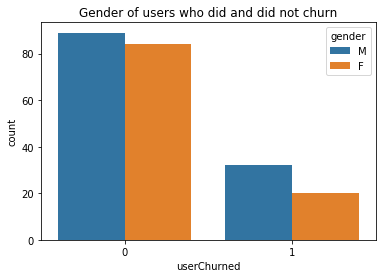

In [45]:
create_bar_of_counts_plot(user_log, 'gender', 'Gender', 'small')

## *Level column: bar plot*

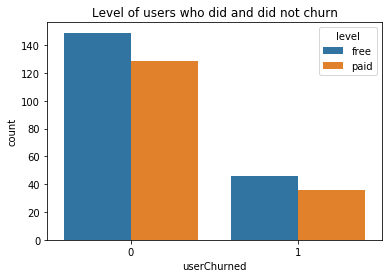

In [46]:
create_bar_of_counts_plot(user_log, 'level', 'Level', 'small')

## *Page column: bar plot*

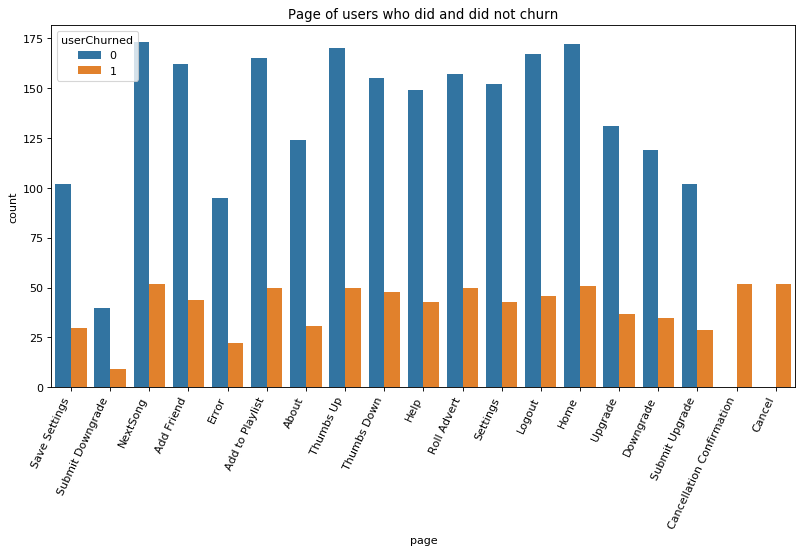

In [47]:
create_bar_of_counts_plot(user_log, 'page', 'Page', 'large')

## *Let's make more meaningful columns for location and userAgent*

**location**: This column will become more meaningful being split into both a city and a state.

**userAgent**: This column can also be split, as it contains information on the platform and browser of the user's particular device.

In [48]:
ua_list = user_log.select(['userAgent']).collect()

ua_list = [re.search(r'\(([^\)]*)\)', str(i[0]) )[0].split(';')[0].replace('(', '').replace(')', '') for i in ua_list]
ua_list = list(dict.fromkeys(ua_list))
print(ua_list)

['Windows NT 6.1', 'Macintosh', 'Windows NT 6.0', 'Windows NT 6.2', 'iPhone', 'Windows NT 6.3', 'iPad', 'compatible', 'X11', 'Windows NT 5.1']


In [49]:
# Create necessary functions for UDFs

def get_platform(x):
    """
    Checks UA String for possible platforms that are referenced within the string.
    """
    if 'compatible' in x:
        return 'Windows'
    elif 'iPad' in x:
        return 'iPad'
    elif 'iPhone' in x:
        return 'iPhone'
    elif 'Macintosh' in x:
        return 'Mac'
    elif 'Windows NT 5.1' in x:
        return 'Windows'
    elif 'Windows NT 6.0' in x:
        return 'Windows'
    elif 'Windows NT 6.1' in x:
        return 'Windows'
    elif 'Windows NT 6.2' in x:
        return 'Windows'
    elif 'Windows NT 6.3' in x:
        return 'Windows'
    elif 'X11' in x:
        return 'Linux'
    
def get_browser(x):
    """
    Checks UA String for possible browsers that are referenced within the string.
    """
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return np.NaN

In [50]:
# Create UDFs, and add columns with them
get_browser_udf = udf(get_browser, StringType())
get_platform_udf = udf(get_platform, StringType())

# Adding Columns
user_log = user_log.withColumn( 'browser', get_browser_udf(user_log.userAgent) )
user_log = user_log.withColumn( 'platform', get_platform_udf(user_log.userAgent) )

In [51]:
# Doing the same with location data
def get_state(x):
    """
    Splits ccolumn values on a ", " and retrieves the state entry.
    """
    return x.split(', ')[1]

def get_city(x):
    """
    Splits column values on a ", " and retrieves the city entry.
    """
    return x.split(', ')[0]

In [52]:
get_state_udf = udf(get_state, StringType())
get_city_udf = udf(get_city, StringType())

user_log = user_log.withColumn( 'state', get_state_udf(user_log.location) )
user_log = user_log.withColumn( 'city', get_city_udf(user_log.location) )

## *Browser column: bar plot*

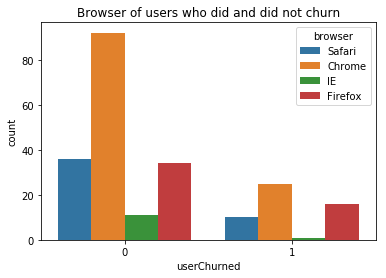

In [53]:
create_bar_of_counts_plot(user_log, 'browser', 'Browser', 'small')

## *Platform column: bar plot*

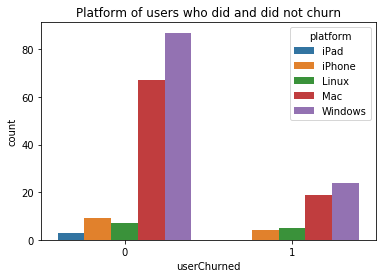

In [54]:
create_bar_of_counts_plot(user_log, 'platform', 'Platform', 'small')

## *State column: bar plot*

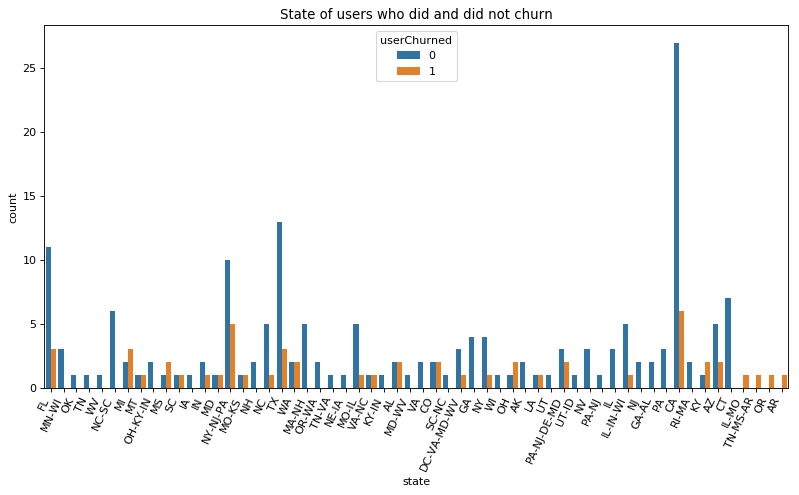

In [55]:
create_bar_of_counts_plot(user_log, 'state', 'State', 'large')

## *City column: bar plot*

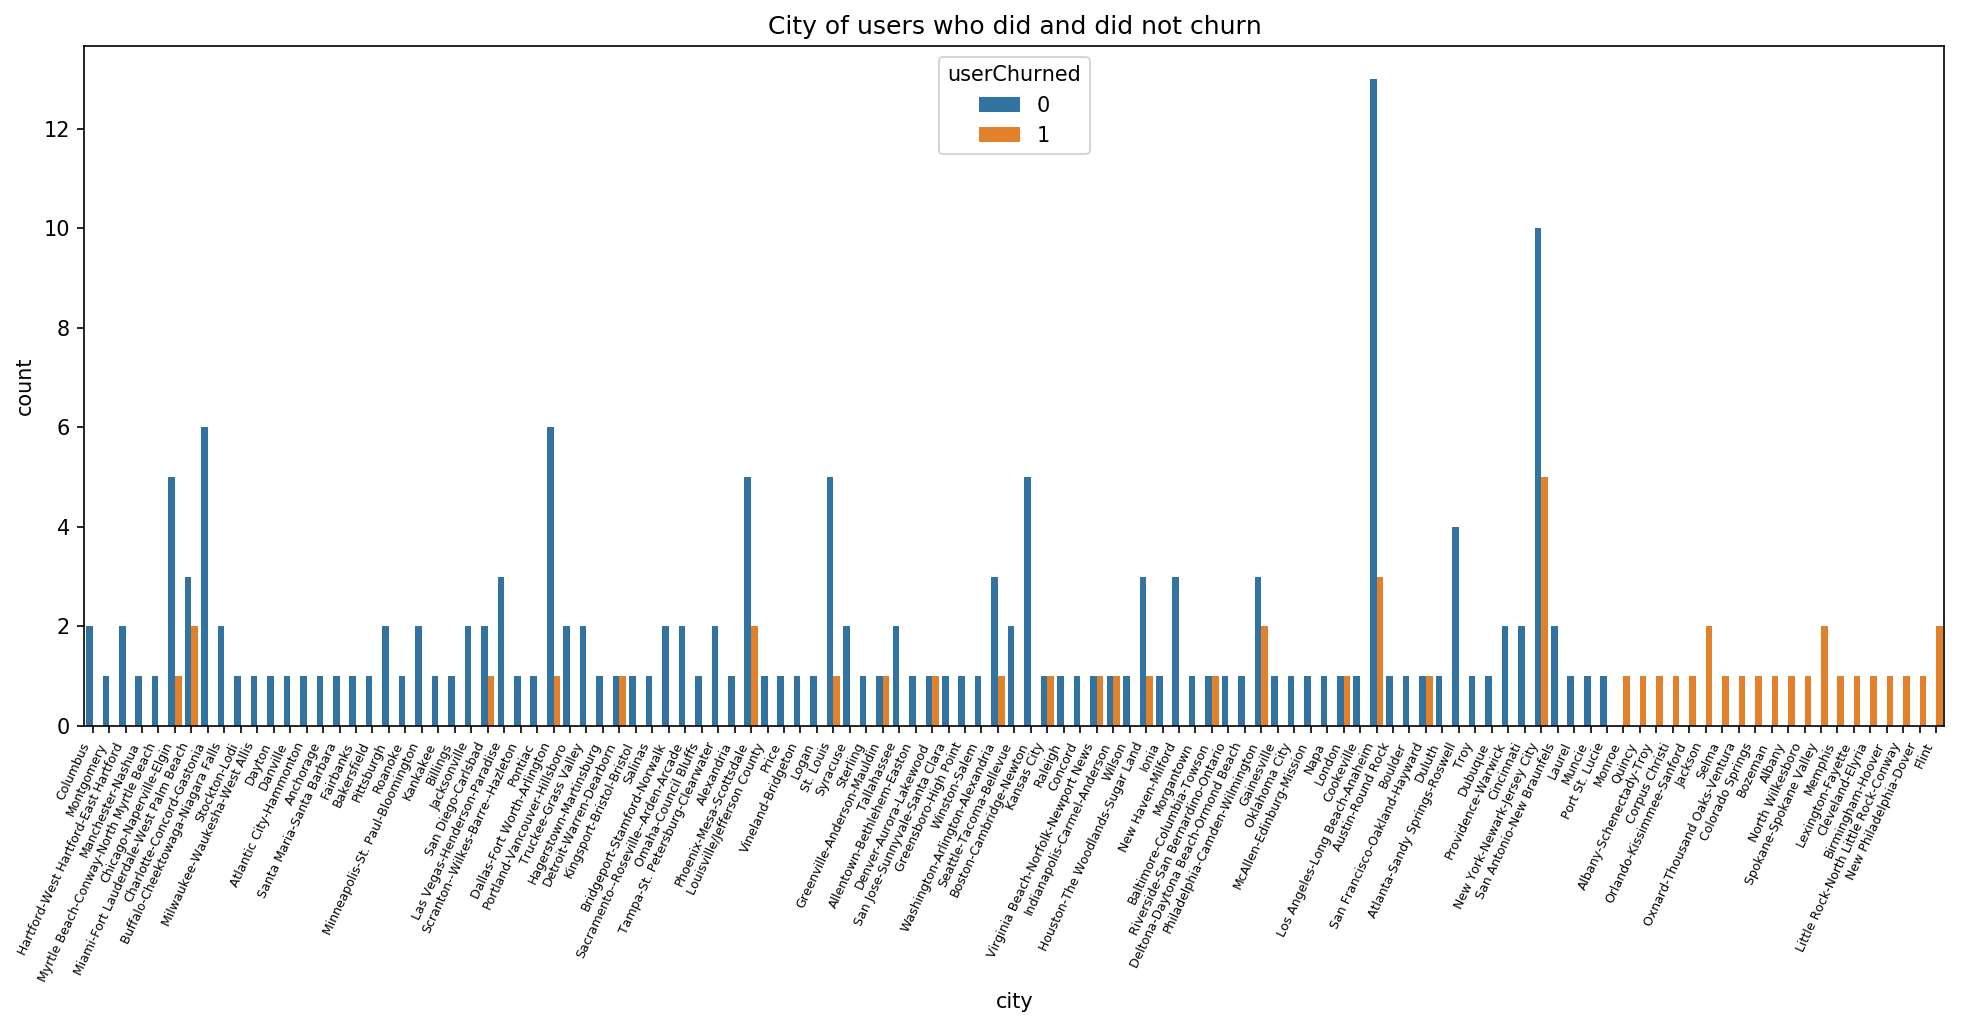

In [56]:
create_bar_of_counts_plot(user_log, 'city', 'City', 'x-large')

## *Artist column: total distinct artists*
Maybe, people who do not like the music service do not explore as many artists.

In [57]:
def visualize_box_and_whisker(df, column):
    """
    For a given column, this generates a box and whisker plot, splitting the user data between those who did or did not churn.
    """
    column_pd = user_log.select(['userId', col(column).alias(column),'userChurned']).drop_duplicates(['userId']).sort("userChurned").toPandas()

    plt.figure()
    sb.boxplot(y=column, x="userChurned", data=column_pd)
    plt.title(column + ' between users who did or did not churn')
    plt.show()

In [58]:
total_distinct_artists_df = user_log.select('userId', 'artist').groupby('userId').agg(countDistinct('artist')).withColumnRenamed('count(DISTINCT artist)', 'totalDistinctArtists')
user_log = user_log.join(total_distinct_artists_df, on='userId')

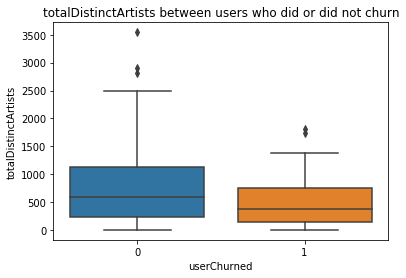

In [59]:
visualize_box_and_whisker(user_log, 'totalDistinctArtists')

## *ItemInSession column: checking average length of a user's session*

In [60]:
session_lengths_per_id_df = user_log.select('userId', 'itemInSession', 'sessionId').groupby(['userId', 'sessionId']).agg(max('itemInSession').alias('lengthPerSession')).sort('userId')
avg_session_length_df = session_lengths_per_id_df.groupBy('userId').avg('lengthPerSession').withColumnRenamed('avg(lengthPerSession)', 'avgSessionLength')

user_log = user_log.join(avg_session_length_df, on='userId')

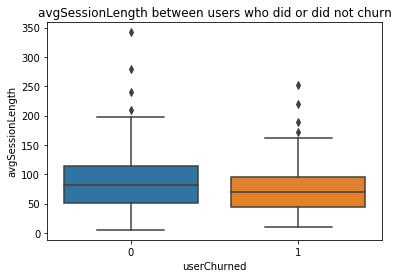

In [61]:
visualize_box_and_whisker(user_log, 'avgSessionLength')

## *SessionId column: let's look at average number of sessions per day*
**First**, we must create a new column value called uniqueDay, to aggregate these values on.

In [62]:
# Create unique day column from timestamp
get_hour = udf(lambda x: math.floor( (x / 1000.0) / (60*60*24) ) )
user_log = user_log.withColumn("uniqueDay", get_hour(user_log.ts))

In [63]:
total_daily_sessions_df = user_log.select('userId', 'sessionId', 'uniqueDay').groupby(['userId', 'uniqueDay']).agg(count('sessionId').alias('totalDailySessions')).sort('userId')
avg_daily_sessions_df = total_daily_sessions_df.groupBy('userId').avg('totalDailySessions').withColumnRenamed('avg(totalDailySessions)', 'avgDailySessions')

user_log = user_log.join(avg_daily_sessions_df, on='userId')

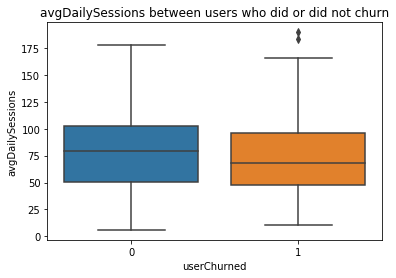

In [64]:
visualize_box_and_whisker(user_log, 'avgDailySessions')

## *Feature Engineering*

In the previous section we looked through the distribution of the data, over the important columns. We also engineered a few features along the way: platform, browser, city, state, totalDistinctArtists, avgSessionLength, and avgDailySessions.

The following feature engineering will mainly take place within the page column, looking at the distribution of the classes over the average number of times a user viewed these pages daily. We will be creating the following columns: durationUsingService, avgDailyThumbsUp, avgDailyThumbsDown, avgDailyErrors, avgDailyAdvertisements, avgDailyNextSongs

In [65]:
def create_avg_daily_page_interaction_column(df, page_interaction, page_title):
    """
    Creates a column that counts the number of times a user interacted with a certain page, in a given day.
    Then, the avg daily value is computed from the total, and joined with the dataframe.
    """
    total_daily_df = df.select('userId', 'page', col('uniqueDay').alias('uniqueDay')).groupby(['userId', 'uniqueDay']).agg(count(when(col("page") == page_interaction, 1)).alias('totalDaily' + page_title)).sort('userId')
    avg_dailydf = total_daily_df.groupBy('userId').avg('totalDaily' + page_title).withColumnRenamed('avg(totalDaily' + page_title + ')', 'avgDaily' + page_title)

    df = df.join(avg_dailydf, on='userId')
    
    return df
    

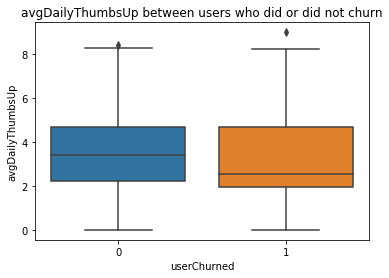

In [66]:
user_log = create_avg_daily_page_interaction_column(user_log, 'Thumbs Up', 'ThumbsUp')
visualize_box_and_whisker(user_log, 'avgDailyThumbsUp')

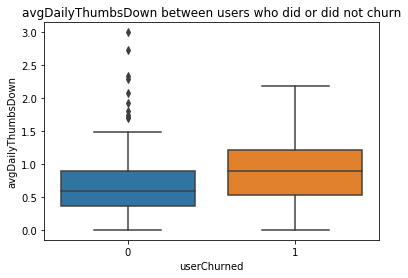

In [67]:
user_log = create_avg_daily_page_interaction_column(user_log, 'Thumbs Down', 'ThumbsDown')
visualize_box_and_whisker(user_log, 'avgDailyThumbsDown')

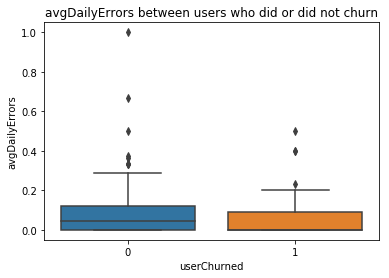

In [68]:
user_log = create_avg_daily_page_interaction_column(user_log, 'Error', 'Errors')
visualize_box_and_whisker(user_log, 'avgDailyErrors')

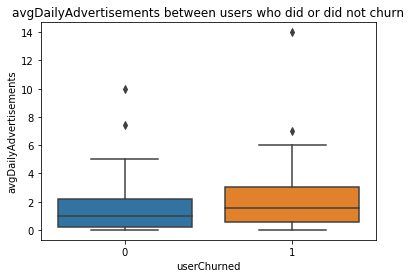

In [69]:
user_log = create_avg_daily_page_interaction_column(user_log, 'Roll Advert', 'Advertisements')
visualize_box_and_whisker(user_log, 'avgDailyAdvertisements')

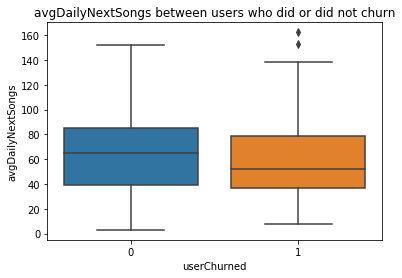

In [70]:
user_log = create_avg_daily_page_interaction_column(user_log, 'NextSong', 'NextSongs')
visualize_box_and_whisker(user_log, 'avgDailyNextSongs')

## *Duration using the service*
Seems to me that this would be a useful feature, as there is probably a higher likelihood of leaving the service, if you have only recently started using it.

In [71]:
duration_using_service_df = user_log.select('userId', 'uniqueDay').groupby('userId').agg(max('uniqueDay') - min('uniqueDay')).withColumnRenamed('(max(uniqueDay) - min(uniqueDay))', 'durationUsingService')
user_log = user_log.join(duration_using_service_df, on='userId')

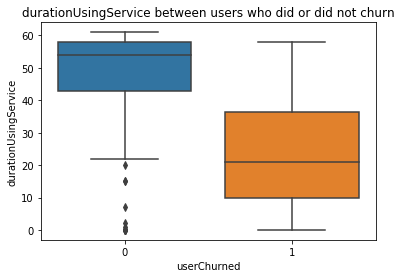

In [72]:
visualize_box_and_whisker('user_log', 'durationUsingService')

## *Select Features and Prepare Model*

- Drop unnecessary columns
- Drop duplicate user ID files, in order to predict churned values for each user

In [73]:
user_log.printSchema()

# gender (cat)
# level (cat)
# browser (cat)
# platform (cat)
# state (cat)
# city (cat)
# totalDistinctArtists (num)
# lengthPerSession (num)
# avgDailySessions (num)
# avgDailyThumbsUp (num)
# avgDailyThumbsDown (num)
# avgDailyErrors (num)
# avgDailyAdvertisements (num)
# avgDailyNextSongs (num)
# durationUsingService (num)

root
 |-- userId: string (nullable = true)
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- Churned: integer (nullable = true)
 |-- userChurned: integer (nullable = true)
 |-- browser: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- state: string (nullable = true)
 |-- city: string (nullable = true)
 |-- totalDistinctArtists: long (nullable = false)
 |-- avgSessionLeng

In [74]:
user_log = user_log.drop('artist', 'auth', 'firstName', 'itemInSession', 'lastName', 'length', 'location', 'method', 'registration', 'sessionId', 'song', 'status', 'ts', 'userAgent', 'Churned', 'uniqueDay', 'page')

user_log = user_log.dropDuplicates(['userId'])


In [75]:
def transform_features_pipeline(df):
    """
    This pipeline vectorizes all of the features, for use in prediction.
    Leverages StringIndexer for categorical data, and VectorAssembler for numerical data.
    Once the categorical variables are indexed, and the numerical data is scaled, VectorAssembler is run again to combine all of the results.
    """
    ### Create pipeline for processing data
    # Categorical Data
    pipeline_stages = [StringIndexer(inputCol=column, outputCol=column+"Index") 
                        for column in ['level','browser', 'platform', 'state', 'city', 'gender'] ]

    # Numerical Data
    assembler = VectorAssembler(inputCols=['avgDailySessions', 'avgSessionLength', 'avgDailyThumbsUp', 'avgDailyThumbsDown', 'avgDailyErrors', 'avgDailyAdvertisements', 'avgDailyNextSongs', 'totalDistinctArtists', 'durationUsingService'], outputCol="features")
    pipeline_stages.append(assembler)

    standard_scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures')
    pipeline_stages.append(standard_scaler)

    # Categorical and Numerical Data
    combined_assembler = VectorAssembler(inputCols=['scaledFeatures','levelIndex', 'browserIndex', 'platformIndex', 'stateIndex', 'cityIndex', 'genderIndex'], outputCol='combinedFeatures')

    pipeline_stages.append(combined_assembler)

    process_pipeline = Pipeline(stages=pipeline_stages)
    
    ### Fit and transform the df into features
    
    df_model = process_pipeline.fit(df).transform(df)

    df_model = df_model.select('userChurned','combinedFeatures').withColumnRenamed('userChurned', 'label')
    
    return df_model
    
    

In [76]:
user_log.cache()

DataFrame[userId: string, gender: string, level: string, userChurned: int, browser: string, platform: string, state: string, city: string, totalDistinctArtists: bigint, avgSessionLength: double, avgDailySessions: double, avgDailyThumbsUp: double, avgDailyThumbsDown: double, avgDailyErrors: double, avgDailyAdvertisements: double, avgDailyNextSongs: double, durationUsingService: double]

In [77]:
user_log_model = transform_features_pipeline(user_log)

## *Split Training and Test Data*

Cache the values to ensure driver does not run out of memory

In [78]:
train, test = user_log_model.randomSplit([0.8, 0.2], seed=42)

train.cache()
test.cache()

DataFrame[label: int, combinedFeatures: vector]

In [79]:
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')
auc_evaluator = BinaryClassificationEvaluator(metricName='areaUnderROC')

def check_model_accuracy(model, train, test):
    """
    Fits the supplied model, and then evaluates accuracy through the F1 score, and area under ROC.
    """
    fitted_model = model.fit(train)
    model_results = fitted_model.transform(test)
    
    f1_score = f1_evaluator.evaluate(model_results.select(col('label'), col('prediction')))
    
    roc_value = auc_evaluator.evaluate(model_results)
    
    return f1_score, roc_value

In [80]:
log_reg = LogisticRegression(featuresCol="combinedFeatures", labelCol="label", maxIter=10)
gbt = GBTClassifier(featuresCol="combinedFeatures", labelCol="label", maxIter=10, maxBins=120)
rf = RandomForestClassifier(featuresCol="combinedFeatures", labelCol="label", maxBins=120)

In [81]:
log_reg_f1, log_reg_roc = check_model_accuracy(log_reg, train, test)

In [82]:
gbt_f1, gbt_roc = check_model_accuracy(gbt, train, test)

In [83]:
rf_f1, rf_roc = check_model_accuracy(rf, train, test)

In [84]:
print(tabulate([['Logistic Regression', log_reg_f1, log_reg_roc], ["Gradient Boosted Trees", gbt_f1, gbt_roc], ["Random Forest", rf_f1, rf_roc]], headers=["Model name", "F1 score", "Area Under R.O.C."]))

Model name                F1 score    Area Under R.O.C.
----------------------  ----------  -------------------
Logistic Regression       0.795518             0.85
Gradient Boosted Trees    0.602683             0.741667
Random Forest             0.719723             0.770833


## *Improve Best Model with CrossValidator*

In [85]:
def check_cv_model_accuracy(model_results):
    """
    Fits the supplied model, and then evaluates accuracy through the F1 score, and area under ROC.
    """
    
    f1_score = f1_evaluator.evaluate(model_results.select(col('label'), col('prediction')))
    
    roc_value = auc_evaluator.evaluate(model_results)
    
    return f1_score, roc_value

In [88]:
log_reg = LogisticRegression(featuresCol="combinedFeatures", labelCol="label")

log_reg_param_grid = ParamGridBuilder().addGrid(log_reg.elasticNetParam, [0, 0.5]).addGrid(log_reg.maxIter, [10, 50]).build()
cross_validator = CrossValidator(estimator = log_reg, estimatorParamMaps = log_reg_param_grid, evaluator = MulticlassClassificationEvaluator(metricName='f1'), numFolds = 3)

In [89]:
cv_model = cross_validator.fit(train)
cv_test_results = cv_model.transform(test)
cv_train_results = cv_model.transform(train)

In [90]:
cv_test_f1, cv_test_roc = check_cv_model_accuracy(cv_test_results)

In [91]:
cv_train_f1, cv_train_roc = check_cv_model_accuracy(cv_train_results)

In [92]:
print(tabulate([["Results on test set", cv_test_f1, cv_test_roc], ["Results on training set", cv_train_f1, cv_train_roc]], headers=["Model results", "F1 score", "Area under R.O.C."]))

Model results              F1 score    Area under R.O.C.
-----------------------  ----------  -------------------
Results on test set        0.795518             0.833333
Results on training set    0.869375             0.904123


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

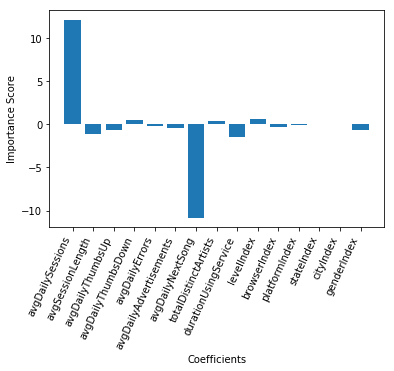

In [94]:
cv_feature_vals = cv_model.bestModel.coefficients
feature_cols = ['avgDailySessions', 'avgSessionLength', 'avgDailyThumbsUp', 'avgDailyThumbsDown', 'avgDailyErrors', 'avgDailyAdvertisements', 'avgDailyNextSong', 'totalDistinctArtists', 'durationUsingService','levelIndex', 'browserIndex', 'platformIndex', 'stateIndex', 'cityIndex', 'genderIndex']

x_pos = np.arange(len(feature_cols))
 
plt.bar(x_pos, cv_feature_vals, align='center')
plt.xticks(x_pos, feature_cols)
plt.ylabel('Importance Score')
plt.xlabel('Coefficients')
plt.xticks(rotation=65, horizontalalignment='right')

In [108]:
print(list(zip(cv_model.avgMetrics, log_reg_param_grid)))

[(0.7695403081098007, {Param(parent='LogisticRegression_d25b5941688a', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_d25b5941688a', name='maxIter', doc='max number of iterations (>= 0).'): 10}), (0.7786866820791636, {Param(parent='LogisticRegression_d25b5941688a', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_d25b5941688a', name='maxIter', doc='max number of iterations (>= 0).'): 50}), (0.7695403081098007, {Param(parent='LogisticRegression_d25b5941688a', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.5, Param(parent='LogisticRegression_d25b5941688a', name='maxIter',

In [109]:
print(tabulate([["0.7695403081098007", "0", "10"], ["0.7786866820791636", "0", "50"], ["0.7695403081098007", "0.5", "10"], ["0.7786866820791636", "0.5", "50"] ], headers=["Avg Metric", "ElasticNetParam", "MaxIter"]))


  Avg Metric    ElasticNetParam    MaxIter
------------  -----------------  ---------
    0.76954                 0           10
    0.778687                0           50
    0.76954                 0.5         10
    0.778687                0.5         50


## Further Steps
* Run these steps on a hadoop cluster to see how the models perform on the large dataset
* Include more metrics about the user that are weekly/monthly
* Define a user journey to count: say the user hits next song, receives an advertisement, and then logs out. Or times where a user listened to more than 10 songs in a session, for example.